In [1]:
# !pip install transformers datasets

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet("processed_data.parquet")

def preprocess_function(examples):
    # input structure: "summarize: description"
    inputs = ["summarize: " + desc for desc in examples["norm_desc"]]
    targets = examples["norm_title"]
    return {"input_text": inputs, "target_text": targets}

In [4]:
# map the preprocess function to the dataset
raw_dataset = Dataset.from_pandas(df[["norm_desc", "norm_title"]])
dataset = raw_dataset.map(preprocess_function, batched=True)
# split the dataset into training and evaluation sets
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

Map:   0%|          | 0/112390 [00:00<?, ? examples/s]

In [5]:
# load the pre-trained T5 model and tokenizer
model_name = "t5-small"  
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
def tokenize_function(examples):
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=256,
        truncation=True,
        padding="max_length"  
    )
    labels = tokenizer(
        examples["target_text"],
        max_length=64,
        truncation=True,
        padding="max_length"  
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/89912 [00:00<?, ? examples/s]

Map:   0%|          | 0/22478 [00:00<?, ? examples/s]

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# here we define the training arguments
training_args = TrainingArguments(
    output_dir="./t5-news-title-generation",
    num_train_epochs=20,
    per_device_train_batch_size=128, 
    per_device_eval_batch_size=128,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=5e-5,
    fp16=True,  
)

# 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# 
trainer.train()

C:\Users\jinch\AppData\Local\Temp\ipykernel_2720\2877389509.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.745300,0.665658
2,0.700700,0.630657
3,0.680100,0.609576
4,0.664900,0.595786
5,0.642000,0.586350
6,0.636000,0.578301
7,0.628400,0.572674
8,0.622900,0.567339
9,0.616200,0.563310
10,0.612200,0.559761


TrainOutput(global_step=14060, training_loss=0.6498996892660475, metrics={'train_runtime': 5710.7631, 'train_samples_per_second': 314.886, 'train_steps_per_second': 2.462, 'total_flos': 1.2168852053950464e+17, 'train_loss': 0.6498996892660475, 'epoch': 20.0})

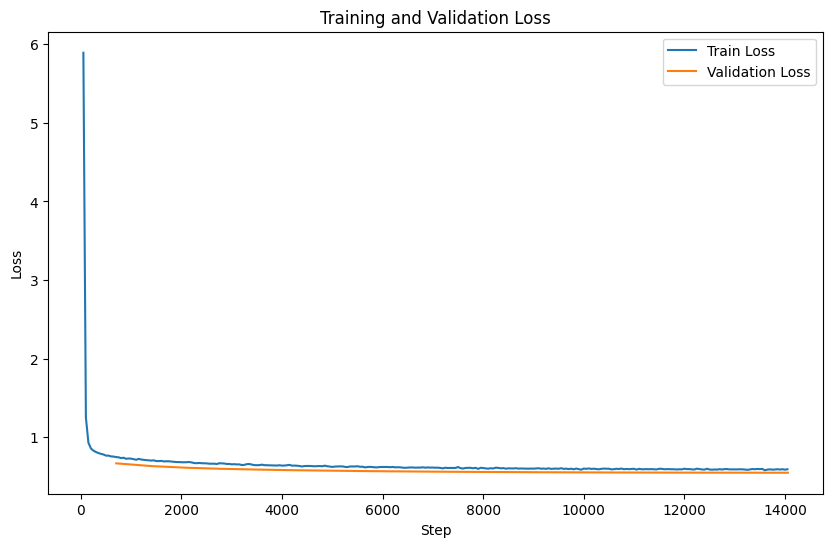

In [8]:
# get the training log history
log_history = trainer.state.log_history

# extract the training and validation loss
train_losses = [entry["loss"] for entry in log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]

steps_train = [entry["step"] for entry in log_history if "loss" in entry]
steps_eval = [entry["step"] for entry in log_history if "eval_loss" in entry]

plt.figure(figsize=(10, 6))
plt.plot(steps_train, train_losses, label="Train Loss")
plt.plot(steps_eval, eval_losses, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [9]:
# generate a title for a given text
def generate_title(text):
    input_text = "summarize: " + text
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=256, truncation=True).to(device)
    outputs = model.generate(inputs, max_length=64, num_beams=4)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generate_title("tokyo ap a lunar orbiter that japan had planned to launch this year could face further delays, possibly until next year or later, because of a funding shortfall and problems developing the probe's informationgathering capabilities, japan's space agency said wednesday. the japan aerospace exploration agency, or jaxa, released a report to a governmentrun commission explaining expected delays to the launch of the 135 million lunara probe..."))
print(generate_title("advanced micro devices inc.'s amd inc.'s 90nanometer notebook processors are on their way to customers, according to a research note published by goldman sachs co. thursday.advertisementintroducing ibm eserver p5 systems.powered by ibms most advanced 64bit microprocessor power5tm, p5 systems can run unix and linux simultaneously. learn more about eserver p5 systems."))

keep_caps>jaxa/Keep_caps> Says keep_caps>mlb/Keep_caps> Lunar Orbiter Could Face Further Delays
keep_caps>amd/Keep_caps>'s 90nanometer Notebook Processors on Way to Customers
